In this part, we'll try to plot the time-course of 1 IC extracted from the EEG of 1 subject on 1 trial.

# First let's extract the time scale data and the time-course data from the .mat file:

In [49]:
import h5py
import numpy as np
import xarray as xr
from utilities import flatten_dict

In [50]:
path = "E:/timot/Documents/1 - Centrale Marseille/0.5 - Semestre S8/Stage/NIC_250819/FCK_LOCKED_IC_JYOTIKA_250819.mat"

mat_file = h5py.File(path, "r")
cells_refs = mat_file['FCK_LOCKED_IC_JYOTIKA']
n_IC, n_subj = cells_refs.shape

# test

In [51]:
def _load_raw_timecourse_256Hz(IC, subj):
    cell = mat_file[cells_refs[IC, subj]]
    raw_timecourse_256Hz = cell['raw_timecourse_256Hz'][:]
    raw_timecourse_256Hz = np.transpose(raw_timecourse_256Hz)
    return raw_timecourse_256Hz

In [52]:
def _load_time_256Hz(IC,subj):
    cell = mat_file[cells_refs[IC, subj]]
    time_256Hz = cell['time_256Hz'][:]
    time_256Hz = np.transpose(time_256Hz)[0]
    return time_256Hz

In [53]:
def _load_freq(IC,subj):
    cell = mat_file[cells_refs[IC, subj]]
    freq = cell['freq'][:]
    freq = np.transpose(freq)[0]
    return freq

In [54]:
time_axis_subj0_IC0 = _load_time_256Hz(0, 0)

In [55]:
time_axis_subj0_IC0

array([-4.        , -3.99609375, -3.9921875 , ...,  2.9921875 ,
        2.99609375,  3.        ])

In [56]:
len(time_axis_subj0_IC0)

1793

In [57]:
raw_timecourse_subj0_IC0 = _load_raw_timecourse_256Hz(0, 0)

In [58]:
raw_timecourse_subj0_IC0.shape

(763, 1793)

In [59]:
freq = _load_freq(0, 0)

In [60]:
freq

array([ 2.        ,  2.57142857,  3.        ,  3.57142857,  4.        ,
        4.57142857,  5.        ,  5.57142857,  6.        ,  6.57142857,
        7.        ,  7.57142857,  8.        ,  8.57142857,  9.        ,
        9.57142857, 10.        , 10.57142857, 11.        , 11.57142857,
       12.        , 12.57142857, 13.        , 13.57142857, 14.        ,
       14.57142857, 15.        , 15.57142857, 16.        , 16.57142857,
       17.        , 17.57142857, 18.        , 18.57142857, 19.        ,
       19.57142857, 20.        , 20.57142857, 21.        , 21.57142857,
       22.        , 22.57142857, 23.        , 23.57142857, 24.        ,
       24.57142857, 25.        , 25.57142857, 26.        , 26.57142857,
       27.        , 27.57142857, 28.        , 28.57142857, 29.        ,
       29.57142857, 30.        , 30.57142857, 31.        , 31.57142857,
       32.        , 32.57142857, 33.        , 33.57142857, 34.        ,
       34.57142857, 35.        , 35.57142857, 36.        , 36.57

# Now that we have the expected data, we plot the time-course:

In [61]:
import mne
from sklearn.decomposition import PCA
from hmmlearn import hmm
import scipy.signal as signal
import matplotlib.pyplot as plt

Text(0, 0.5, 'Potentiel (eV)')

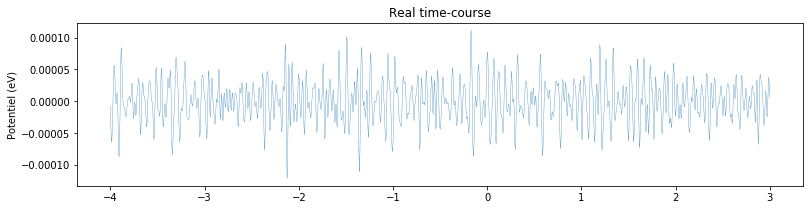

In [62]:
plt.figure(figsize=(13, 3))
plt.title('Real time-course')
plt.plot(time_axis_subj0_IC0, raw_timecourse_subj0_IC0[0,:], linewidth=.3)
plt.ylabel('Potentiel (eV)')

# Let's not wait any longer and try to plot a wavelet transform!

In [84]:
shape = raw_timecourse_subj0_IC0.shape

In [85]:
shape

(763, 1793)

In [86]:
raw_timecourse_subj0_IC0[0]

array([-7.50833845e-06, -3.42053131e-05, -5.47569765e-05, ...,
        2.80652243e-05,  7.30566021e-06,  7.30566021e-06])

In [87]:
raw_timecourse_subj0_IC0[0].shape

(1793,)

### !!! A ne surtout pas faire :
Le reshape qui ne transpose pas du tout la matrice !!

In [88]:
test2 = raw_timecourse_subj0_IC0.reshape(shape[1],shape[0])

In [89]:
test2[:,0]

array([-7.50833845e-06, -3.08701141e-05, -3.12019658e-05, ...,
       -6.43404248e-06,  2.19998913e-05, -9.94637275e-06])

In [90]:
test2[:,0].shape

(1793,)

In [69]:
test3 = test2[np.newaxis,np.newaxis,:,0]
test3.shape

(1, 1, 1793)

In [70]:
test3[0,0].shape

(1793,)

In [71]:
test4 = test3[0, 0, np.newaxis, :]
for i in range(1,test2.shape[1]):
    test4 = np.append(test4, test2[np.newaxis, :, i], axis=0)
test4.shape

(763, 1793)

Par conséquent, ce wavelet transform n'a pas de sens physique :

In [92]:
# Use MNE to extract TFR
info = mne.create_info(ch_names=['signal'], sfreq=256, ch_types=['eeg'])
raw = mne.EpochsArray(test4[0, np.newaxis, np.newaxis, :], info, verbose=False) # x.reshape(1, -1)[np.newaxis, :, :]
n_cycles = freq/2

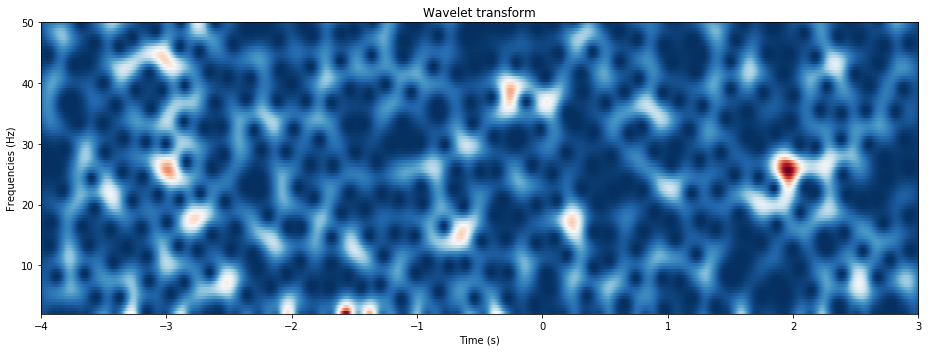

In [93]:
tfr = mne.time_frequency.tfr_morlet(raw, freqs=freq, n_cycles=n_cycles, picks='eeg', return_itc=False)

plt.figure(figsize=(13, 5))
plt.title('Wavelet transform')
plt.imshow(tfr._data[0][:, :], aspect='auto', origin='lower', extent=[-4, 3, 2, 50], cmap='RdBu_r')
plt.xlabel('Time (s)')
plt.ylabel('Frequencies (Hz)')
plt.tight_layout()
plt.savefig('tde-hmm.png', dpi=600)

In [94]:
# Use MNE to extract TFR
raw = mne.EpochsArray(test4[:, np.newaxis, :], info, verbose=False) # x.reshape(1, -1)[np.newaxis, :, :]

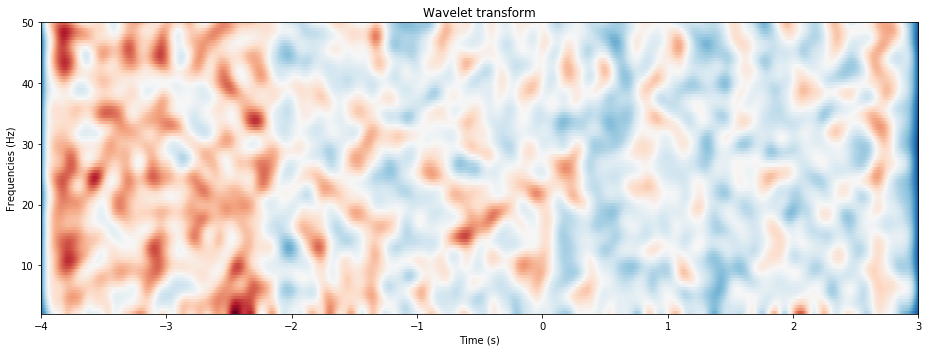

In [95]:
tfr = mne.time_frequency.tfr_morlet(raw, freqs=freq, n_cycles=n_cycles, picks='eeg', return_itc=False)

plt.figure(figsize=(13, 5))
plt.title('Wavelet transform')
plt.imshow(tfr._data[0][:, :], aspect='auto', origin='lower', extent=[-4, 3, 2, 50], cmap='RdBu_r')
plt.xlabel('Time (s)')
plt.ylabel('Frequencies (Hz)')
plt.tight_layout()
plt.savefig('tde-hmm.png', dpi=600)